<a href="https://colab.research.google.com/github/Chiosas/Keypoints/blob/master/Apparel_Keypoints_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'keypoints'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

if IN_COLAB and FIRST_RUN:
    !pip install -q -U --pre efficientnet

### ***Data Download***

In [0]:
DRIVE_DIR = Path('drive/My Drive/Capstone')

In [0]:
import shutil

if IN_COLAB and FIRST_RUN:
    archive_files = [
        'fashionAI_keypoints_train1.tar',
        'fashionAI_keypoints_train2.tar',
        'fashionAI_keypoints_test.tar',
    ]
    for filename in archive_files:
        shutil.unpack_archive(DRIVE_DIR/filename, DATA_DIR, 'tar')

In [0]:
if IN_COLAB and FIRST_RUN:
    for folder in os.listdir(DATA_DIR):
        place = folder if folder == 'test' else folder[:-1]
        for folder_name in os.listdir(DATA_DIR/folder/'Images'):
            shutil.move(DATA_DIR/folder/'Images'/folder_name, DATA_DIR/place/folder_name)
        shutil.move(DATA_DIR/folder/f'{place}.csv', DATA_DIR/place/(f'{folder}.csv'))
        if folder == 'test':
            shutil.rmtree(DATA_DIR/folder/'Images')
        else:
            shutil.rmtree(DATA_DIR/folder)

### ***Importing Dependencies***

In [8]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras

TensorFlow 2.x selected.


In [9]:
tf.__version__

'2.1.0'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import efficientnet.tfkeras as efn

import PIL
import math
import pickle

from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***

### ***Content - Apparel Keypoints Dataset***


**Introduction**

Machine analysis of apparel could easily be affected by the dimension and shape of clothes, the distance and angle of camera shooting, and even how the apparel is displayed or the model is posing. Detection of apparel keypoints in images can help to improve the performance of applications such as alignment of clothes, recognition of clothes local attributes and auto-editing of apparel images.

We provide a dataset for key point localization of the apparel in practical scenarios. In this dataset, a set of clothing keypoints is defined on the basis of fashion design. The set is further refined into six subsets according to the following six women apparel categories: blouse, outwear, trousers, skirt, dress and jumpsuit, respectively. Currently, the dataset of the first five categories is open for download (the jumpsuit category is omitted since it is uncommon in the real-world scenario), including 41 sub-categories and 24 kinds of keypoints in total. There are altogether 100,000 annotated images in this dataset.


![Key_Points](https://work.alibaba-inc.com/aliwork_tfs/g01_alibaba-inc_com/tfscom/TB16Z8fXQCWBuNjy0FaXXXUlXXa.tfsprivate.jpg)


**Data Description**

*Image data*

All image data are from Alibaba e-Commerce platform. We randomly collected data with the following three standards:
1) The images fall into the five aforementioned categories as evenly as possible;
2) There are approximately an even number of single-model images and tiled single-piece images;
3) There are approximately an even number of simple-background and complex-background images.

*Keypoint Definition*

There are totally 24 type of keypoints, but not every cloth category needs to cover all those keypoints. For example, there are only 7 keypoints in trousers, with other keypoints inexistent, such as left/right necklines.

*Annotation Format*

Annotation file is saved in a csv-format table with a total of 26 columns: the first column (image_id) contains image file name, the second column (image_category) denotes the category that an image belongs to, and the remaining 24 columns record the positions of the aforementioned 24 keypoints, respectively.

Each keypoint is represented by a triple whoes elements are connected by underscores, denoted as "x_y_v", where the x and y are coordinates, and v is visibility. Visibility equals 1 if a keypoint is visible, 0 if it is occluded, and -1 if it is inexistent or undefined in the category.

*Training Data*

One folder and an annotation file can be found after decompressing the training data package.
- *Images* folder contains test images in jpeg format.
- *train.csv* contains annotation of training images. 


###***Making Image Dataframes***

In [0]:
# Setting folder names for train and test data
train_dir = 'train'
test_dir = 'test'

In [0]:
# Reading the data from the file
train1_data = pd.read_csv(DATA_DIR/train_dir/'train1.csv', low_memory=False)
train2_data = pd.read_csv(DATA_DIR/train_dir/'train2.csv', low_memory=False)

raw_data = pd.concat([train1_data, train2_data])

In [15]:
raw_data.head(2).T

,0,1
image_id,Images/blouse/0003e38fe17e564f49e1ccef5020d269...,Images/blouse/00043c6d051d3469b38b6cd203f5622c...
image_category,blouse,blouse
neckline_left,229_121_1,200_161_1
neckline_right,282_117_1,323_156_1
center_front,256_138_1,262_183_1
shoulder_left,177_170_1,192_169_1
shoulder_right,337_148_1,327_168_1
armpit_left,201_236_1,191_202_0
armpit_right,328_226_1,336_207_0
waistline_left,-1_-1_-1,-1_-1_-1


In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76866 entries, 0 to 32142
Data columns (total 26 columns):
image_id            76866 non-null object
image_category      76866 non-null object
neckline_left       76866 non-null object
neckline_right      76866 non-null object
center_front        76866 non-null object
shoulder_left       76866 non-null object
shoulder_right      76866 non-null object
armpit_left         76866 non-null object
armpit_right        76866 non-null object
waistline_left      76866 non-null object
waistline_right     76866 non-null object
cuff_left_in        76866 non-null object
cuff_left_out       76866 non-null object
cuff_right_in       76866 non-null object
cuff_right_out      76866 non-null object
top_hem_left        76866 non-null object
top_hem_right       76866 non-null object
waistband_left      76866 non-null object
waistband_right     76866 non-null object
hemline_left        76866 non-null object
hemline_right       76866 non-null object
crotch   

In [17]:
raw_data.describe(include='all').T

,count,unique,top,freq
image_id,76866,76866,Images/blouse/1c8f3b2865dffa040a990cae75895555...,1
image_category,76866,5,blouse,16613
neckline_left,76866,25087,-1_-1_-1,32234
neckline_right,76866,25465,-1_-1_-1,32232
center_front,76866,16282,-1_-1_-1,46395
shoulder_left,76866,23671,-1_-1_-1,34444
shoulder_right,76866,24512,-1_-1_-1,34474
armpit_left,76866,29320,-1_-1_-1,32304
armpit_right,76866,29635,-1_-1_-1,32317
waistline_left,76866,9462,-1_-1_-1,64517


In [0]:
image_data = raw_data.copy()

In [0]:
class KeyPoint:
    '''
    Apparel Key Point class represented by data elements where the x and y are coordinates, p is presence and v is visibility
    '''

    def __init__(self, x_coord=None, y_coord=None, visible=None, present=None):
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.visible = visible
        self.present = present
    
    def __repr__(self):
        return (f'{self.__class__.__name__}('
                f'{self.x_coord!r}, {self.y_coord!r}, '
                f'{self.visible!r}, {self.present!r})')
    
    def __str__(self):
        return f'Coordinates (x, y): {self.x_coord}, {self.y_coord}; Visible: {bool(self.visible)}; Present: {bool(self.present)}'

In [0]:
def read_annotation(anno):
    '''
    Keypoint annotation is represented as "x_y_v", where the x and y are coordinates, and v is visibility
    '''
    x, y, v = map(int, anno.split(sep='_'))
    keypoint = KeyPoint(x, y, int(v > 0), int(v >= 0))
    
    return keypoint

In [0]:
def update_image_df(image_df, anno_cols):
    image_df['Image'] = image_df['image_id'].apply(lambda x: x.split(sep='/')[-1])
    image_df['Path'] = image_df['image_id'].apply(lambda x: str(DATA_DIR/train_dir/x.split(sep='/')[1]))
    image_df['Image_Path'] = image_df['Path'] + '/' + image_df['Image']

    image_df['Image_Dims'] = image_df['Image_Path'].apply(lambda x: PIL.Image.open(x).size)
    image_df['Image_Width'] = image_df['Image_Dims'].apply(lambda x: x[0])
    image_df['Image_Height'] = image_df['Image_Dims'].apply(lambda x: x[1])

    for col in anno_cols:
        image_df[f'{col}_obj'] = image_df[col].apply(read_annotation)

    return image_df

In [22]:
anno_cols = list(image_data.columns)[2:]
image_data = update_image_df(image_data, anno_cols)
image_data = image_data.drop(columns=anno_cols)
image_data.head(2).T

,0,1
image_id,Images/blouse/0003e38fe17e564f49e1ccef5020d269...,Images/blouse/00043c6d051d3469b38b6cd203f5622c...
image_category,blouse,blouse
Image,0003e38fe17e564f49e1ccef5020d269.jpg,00043c6d051d3469b38b6cd203f5622c.jpg
Path,data/keypoints/train/blouse,data/keypoints/train/blouse
Image_Path,data/keypoints/train/blouse/0003e38fe17e564f49...,data/keypoints/train/blouse/00043c6d051d3469b3...
Image_Dims,"(512, 512)","(512, 512)"
Image_Width,512,512
Image_Height,512,512
neckline_left_obj,"Coordinates (x, y): 229, 121; Visible: True; P...","Coordinates (x, y): 200, 161; Visible: True; P..."
neckline_right_obj,"Coordinates (x, y): 282, 117; Visible: True; P...","Coordinates (x, y): 323, 156; Visible: True; P..."


###***Exploring image data***

In [23]:
# Shape of image dataframe
print('Number of rows in the dataset:', image_data.shape[0])
print('Number of columns in the dataset:', image_data.shape[1])

Number of rows in the dataset: 76866
Number of columns in the dataset: 32


In [0]:
# Column names to explore
img_h_col = 'Image_Height'
img_w_col = 'Image_Width'
class_col = 'image_category'
record_col = 'Image'

In [25]:
# Number of Classes
class_num = image_data[class_col].nunique()
class_num

5

In [26]:
# Image count by Class
image_data[class_col].value_counts().sort_values(ascending=False)

blouse      16613
skirt       16522
trousers    15621
outwear     14167
dress       13943
Name: image_category, dtype: int64

In [0]:
def img_bar_plot(data_df, feature, target):
    # Counting feature instances by target class
    class_df = data_df[[feature, target]].groupby(target, as_index=False).count()
    class_df = class_df.sort_values(by=feature, ascending=False).reset_index(drop=True)
    order_labels = list(class_df[target])

    # Setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 0.75 * class_df[target].nunique()))

    # Rendering plot
    sns.barplot(x=feature, y=target, data=class_df, edgecolor='black', orient='h', order=order_labels)

    # Adding chart title
    plt.title('Number of Records per Class', size=14)

    # Adding custom labels for axes
    plt.ylabel('Class')
    plt.xlabel('# of Records')

    # Adding labels on data points
    for index, row in class_df.iterrows():
        plt.text(row[feature] + class_df[feature].max() * 0.05, index, f'{row[feature]}', color='black', ha="center", size=11)

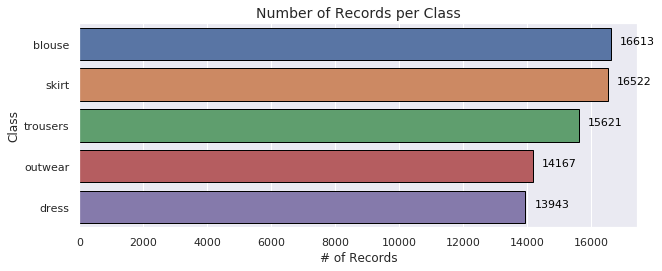

In [28]:
img_bar_plot(image_data, record_col, class_col)

In [0]:
def imgdims_scatter_plot(data_df, height, width, image):
    # Getting image dimensions
    img_dims_df = data_df[[image, height, width]]

    # Setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 4))

    # Rendering plot
    sns.scatterplot(x=width, y=height, hue=image, data=img_dims_df)

    # Adding chart title
    plt.title('Image dimensions variance', size=14)

    # Adding custom labels for axes
    plt.ylabel('Image Height')
    plt.xlabel('Image Width')

    # Adding custom legend title
    plt.legend(title='Class')

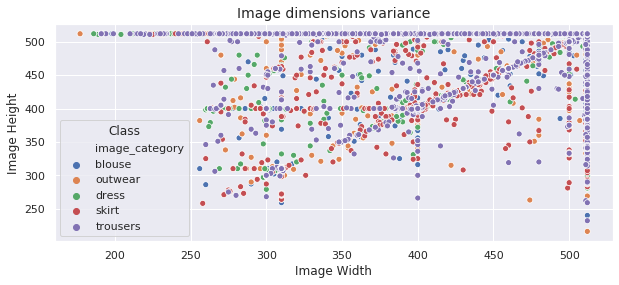

In [30]:
imgdims_scatter_plot(image_data, img_h_col, img_w_col, class_col)

In [31]:
# Variation of image dimensions
print(f"Image dimensions vary from {image_data[img_h_col].min()} to {image_data[img_h_col].max()} pixels in height.")
print(f"And from {image_data[img_w_col].min()} to {image_data[img_w_col].max()} pixels in width.")

Image dimensions vary from 216 to 512 pixels in height.
And from 177 to 512 pixels in width.


## ***Data Preparation***

###***Data Split - Train/Validation***

In [0]:
def data_split(data=None, size=0.2, save_data=False, load_data=False):
    # Setting variables
    train_data, val_data, test_data = None, None, None
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.pkl', 'val_data.pkl', 'test_data.pkl']

    if type(data)==type(pd.DataFrame()):
        # Data split part
        train_data, testval_data = train_test_split(data, test_size=size, random_state=10, stratify=data[class_col])
        val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[class_col])

        # Assigning file data contents
        file_contents = [train_data, val_data, test_data]

        # Reseting indices on data
        for contents in file_contents:
            contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_pickle(DATA_DIR/name)
    
    # Loading data from csv files
    if load_data:
        for pos, name in enumerate(file_names):
            file_contents[pos] = pd.read_pickle(DATA_DIR/name)

        train_data, val_data, test_data = file_contents

    return train_data, val_data, test_data

In [0]:
# Spliting data into train, validation and test sets
train_data, val_data, test_data = data_split(image_data, size=0.2, save_data=True, load_data=True)

In [0]:
def sample_split(data=None, size=0.2):
    if type(data)==type(pd.DataFrame()):
        # Data split part
        _, sample_data = train_test_split(data, test_size=size, random_state=10, stratify=data[class_col])
        
        # Reseting indices on data
        sample_data.reset_index(drop=True, inplace=True)

    return sample_data

In [0]:
# Using smaller size data for testing
SAMPLE = True

if SAMPLE:
    train_data = sample_split(train_data, size=0.3)

In [36]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(18448, 32), (7687, 32), (7687, 32)]

In [37]:
train_data.head(2).T

,0,1
image_id,Images/blouse/73e091e9fbd213f1bdc9f2dbcf4b8e42...,Images/trousers/b390efb9cd007d15e89db6a1587beb...
image_category,blouse,trousers
Image,73e091e9fbd213f1bdc9f2dbcf4b8e42.jpg,b390efb9cd007d15e89db6a1587beb93.jpg
Path,data/keypoints/train/blouse,data/keypoints/train/trousers
Image_Path,data/keypoints/train/blouse/73e091e9fbd213f1bd...,data/keypoints/train/trousers/b390efb9cd007d15...
Image_Dims,"(512, 512)","(362, 512)"
Image_Width,512,362
Image_Height,512,512
neckline_left_obj,"Coordinates (x, y): 223, 110; Visible: True; P...","Coordinates (x, y): -1, -1; Visible: False; Pr..."
neckline_right_obj,"Coordinates (x, y): 280, 112; Visible: True; P...","Coordinates (x, y): -1, -1; Visible: False; Pr..."


### ***Data Preprocessing***

In [0]:
def feature_encode(data, feature, fit_data=False, transform_data=False):
    # Setting variables
    data = data.copy()
    file_name = 'class_encoder.pkl'
    classes = data[feature].unique()

    # Saving feature encoder to pickle file
    if fit_data:
        encoder = OneHotEncoder(categories=[classes])
        encoder.fit(data[[feature]])

        with open(MODEL_DIR/file_name, 'wb') as f:
            pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    # Loading feature encoder from pickle file
    if transform_data:
        with open(MODEL_DIR/file_name, 'rb') as f:
            encoder = pickle.load(f)
        f.close()

        data[f'{feature}_enc'] = [element for element in encoder.transform(data[[feature]]).toarray()]

    return data, encoder

In [0]:
train_data, encoder = feature_encode(train_data, class_col, fit_data=True, transform_data=True)
val_data, _ = feature_encode(val_data, class_col, transform_data=True)

In [40]:
encoder.categories_

[array(['blouse', 'trousers', 'outwear', 'skirt', 'dress'], dtype=object)]

In [41]:
train_data.head(2).T

,0,1
image_id,Images/blouse/73e091e9fbd213f1bdc9f2dbcf4b8e42...,Images/trousers/b390efb9cd007d15e89db6a1587beb...
image_category,blouse,trousers
Image,73e091e9fbd213f1bdc9f2dbcf4b8e42.jpg,b390efb9cd007d15e89db6a1587beb93.jpg
Path,data/keypoints/train/blouse,data/keypoints/train/trousers
Image_Path,data/keypoints/train/blouse/73e091e9fbd213f1bd...,data/keypoints/train/trousers/b390efb9cd007d15...
Image_Dims,"(512, 512)","(362, 512)"
Image_Width,512,362
Image_Height,512,512
neckline_left_obj,"Coordinates (x, y): 223, 110; Visible: True; P...","Coordinates (x, y): -1, -1; Visible: False; Pr..."
neckline_right_obj,"Coordinates (x, y): 280, 112; Visible: True; P...","Coordinates (x, y): -1, -1; Visible: False; Pr..."


In [0]:
def labels_encode(data, labels):
    data = data.copy()

    for label in labels:
        data[f'{label}_enc'] = [
            [
                element[1].x_coord / element[0][0] if element[1].present else 0.,
                element[1].y_coord / element[0][1] if element[1].present else 0.,
                float(element[1].visible),
                float(element[1].present)
            ] for element in zip(data['Image_Dims'], data[f'{label}_obj'])
        ]

    return data

In [0]:
train_data = labels_encode(train_data, anno_cols)
val_data = labels_encode(val_data, anno_cols)

In [44]:
train_data.head(2).T

,0,1
image_id,Images/blouse/73e091e9fbd213f1bdc9f2dbcf4b8e42...,Images/trousers/b390efb9cd007d15e89db6a1587beb...
image_category,blouse,trousers
Image,73e091e9fbd213f1bdc9f2dbcf4b8e42.jpg,b390efb9cd007d15e89db6a1587beb93.jpg
Path,data/keypoints/train/blouse,data/keypoints/train/trousers
Image_Path,data/keypoints/train/blouse/73e091e9fbd213f1bd...,data/keypoints/train/trousers/b390efb9cd007d15...
Image_Dims,"(512, 512)","(362, 512)"
Image_Width,512,362
Image_Height,512,512
neckline_left_obj,"Coordinates (x, y): 223, 110; Visible: True; P...","Coordinates (x, y): -1, -1; Visible: False; Pr..."
neckline_right_obj,"Coordinates (x, y): 280, 112; Visible: True; P...","Coordinates (x, y): -1, -1; Visible: False; Pr..."


### ***Dataset Creation***

In [0]:
def image_parse(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=IMG_CHANNELS)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    return image

In [0]:
def image_resize(image, img_dims):
    image = tf.image.resize(image, img_dims)
    
    return image

In [0]:
def image_augment(image, level=0):
    if level > 0:
        delta = 0.1 * level
        lower = 1 - delta
        upper = 1 + delta
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.image.random_brightness(image, max_delta=delta)
        image = tf.image.random_hue(image, max_delta=delta)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    image_size,
    image_aug_level=0,
    prefetch=1,
    shuffle=False,
    num_parallel_calls=1,
):
    filenames = np.array([f'{getattr(row, x[0])}' for row in df.itertuples()])
    classes = np.array([getattr(row, x[1]) for row in df.itertuples()])
    labels = np.array([[getattr(row, label) for label in y] for row in df.itertuples()])

    dataset_length = len(filenames)

    parse_fn = image_parse
    resize_fn = partial(image_resize, img_dims=(image_size, image_size))
    augment_fn = partial(image_augment, level=image_aug_level)

    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(resize_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
     )
    class_ds = tf.data.Dataset.from_tensor_slices(classes)
    feature_ds = tf.data.Dataset.zip((image_ds, class_ds))

    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    dataset = tf.data.Dataset.zip((feature_ds, label_ds))

    if shuffle:
        dataset = dataset.shuffle(dataset_length)

    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    if prefetch:
        dataset = dataset.prefetch(prefetch)
    return dataset, dataset_length, batch_size

In [0]:
path_col = 'Image_Path'
category_col = f'{class_col}_enc'

feature_cols = [path_col, category_col]
keypoint_cols = [f'{anno}_enc' for anno in anno_cols]

BATCH_SIZE = 16
IMG_SIZE = 299
IMG_CHANNELS = 3
IMG_AUG_LEVEL = 3

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_data,
    x=feature_cols,
    y=keypoint_cols,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    image_aug_level=IMG_AUG_LEVEL,
    shuffle=True,
    prefetch=tf.data.experimental.AUTOTUNE,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
train_dataset_steps = math.ceil(train_dataset_length / train_batch_size)

In [51]:
train_dataset.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 24, 4), dtype=tf.float64, name=None))

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(4.75 * cols, 4.75 * rows))
    for (x1, x2), y in dataset.take(1):
        for i in range(rows * cols):
            image, category = x1[i], x2[i]
            category = encoder.categories_[0][category.numpy().argmax()]
            idx = i // cols, i % cols if rows > 1 else i % cols
            ax[idx].axis('off')
            ax[idx].set_title(f'Class - {category.title()}')
            ax[idx].imshow(image)
            for point in y[i]:
                if point[3]:
                    color = 'ro' if point[2] else 'bo'
                    ax[idx].plot(point[0] * IMG_SIZE, point[1] * IMG_SIZE, color, markersize=10)

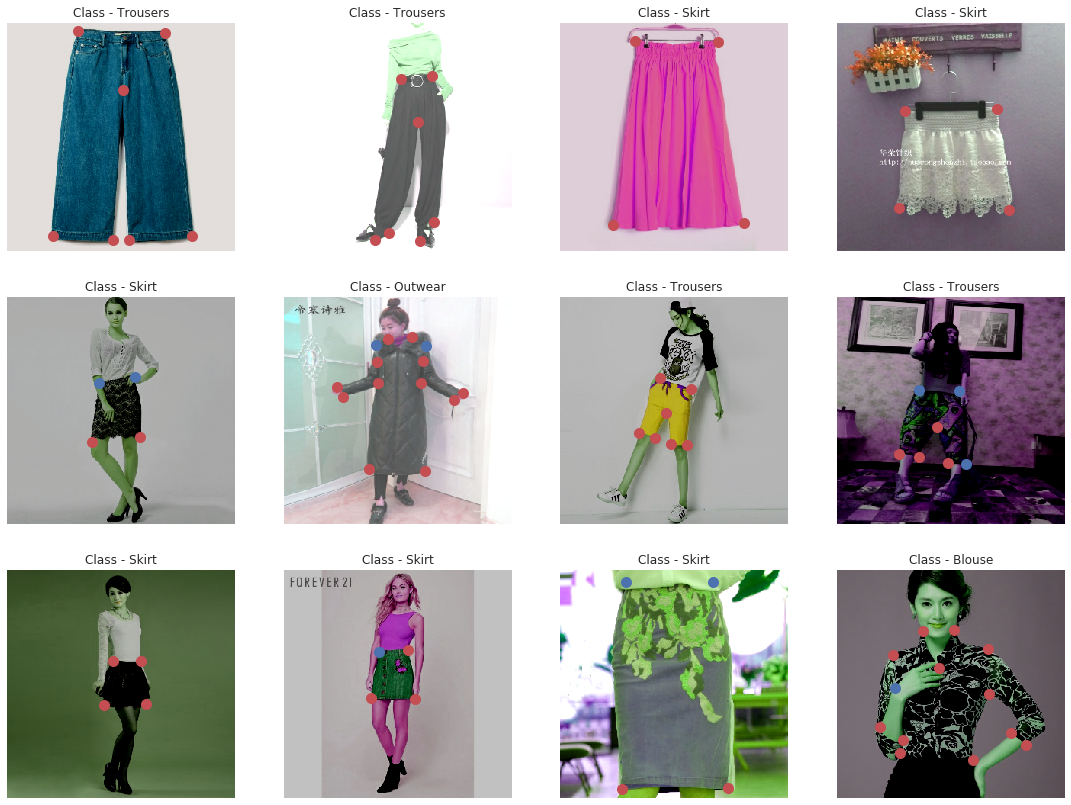

In [53]:
plot_dataset(train_dataset, 3, 4)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_data,
    x=feature_cols,
    y=keypoint_cols,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    prefetch=tf.data.experimental.AUTOTUNE,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
val_dataset_steps = math.ceil(val_dataset_length / val_batch_size)

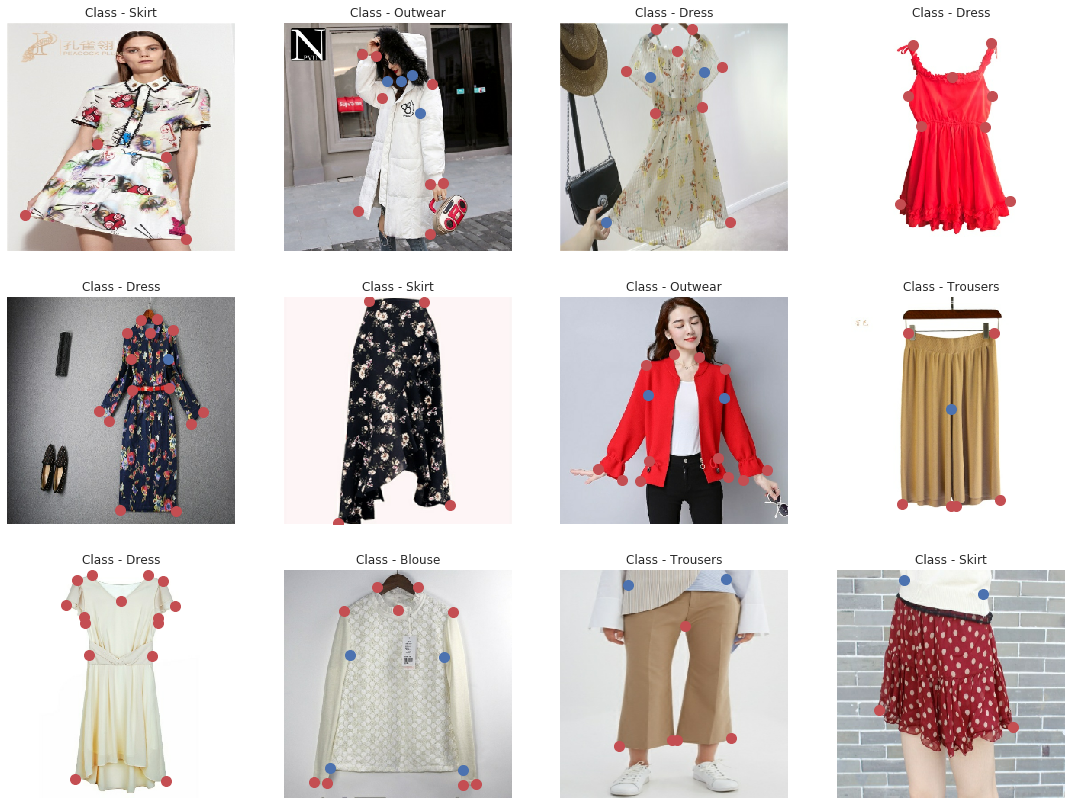

In [55]:
plot_dataset(val_dataset, 3, 4)

## ***Building Model***

### ***Utilities & Setup***

In [0]:
def plot_history(history, contains, skip=0):
    _, ax = plt.subplots(1, len(contains), figsize=(20, 5))

    df = pd.DataFrame(history.history)
    for idx, item in enumerate(contains):
        ax[idx].plot(df[list(df.filter(regex=item))].iloc[skip:])
        ax[idx].set_title(item)

In [0]:
def model_capture(model, name, history, save_model=False, load_model=False):
    # Setting variables
    name = name.strip().replace(' ', '_').lower()
    architecture_path = str(Path(MODEL_DIR/f'{name}_weights.h5'))
    weights_path = str(Path(MODEL_DIR/f'{name}_arch.json'))
    history_path = str(Path(MODEL_DIR/f'{name}_hist.csv'))

    # Saving model weights and architecture into the files
    if save_model:
        model.save_weights(weights_path)
        with open(architecture_path, "w") as f:
            f.write(model.to_json())
        
        pd.DataFrame(history.history).to_csv(path_or_buf=history_path, index=False, header=True)
    
    # Loading model weights and architecture from the files
    if load_model:
        with open(architecture_path, "r") as f:
            model = tf.keras.models.model_from_json(f.read())
        model.load_weights(weights_path)
    
    return model

In [0]:
IMG_DIMS = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
CLASS_DIMS = encoder.categories_[0].shape
KEYPOINT_DIMS = (len(anno_cols), 4)

DROPOUT = 0.2
LEARN_RATE = 3e-4
L1_RATE = 1e-5
L2_RATE = 1e-6

EPOCHS = 20
PATIENCE = min(max(EPOCHS // 10, 3), 5)

In [0]:
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
    tf.keras.callbacks.EarlyStopping(patience=int(PATIENCE * 2.5), restore_best_weights=True),
    tf.keras.callbacks.TerminateOnNaN(),
]

### ***Deep Learning Model***

In [0]:
def make_model(input_dims, output_dims, dropout, l1, l2):
    img_dims, class_dims = input_dims
    n_keypoints, n_params = output_dims
    image_input = tf.keras.layers.Input(shape=img_dims)
    class_input = tf.keras.layers.Input(shape=class_dims)

    imagenet = efn.EfficientNetB6(include_top=False, weights='imagenet')(image_input)
    
    img_x = tf.keras.layers.concatenate([
                tf.keras.layers.GlobalAvgPool2D()(imagenet),
                tf.keras.layers.GlobalMaxPool2D()(imagenet),
    ])
    img_x = tf.keras.layers.BatchNormalization()(img_x)
    img_x = tf.keras.layers.Dropout(dropout)(img_x)

    img_dense = tf.keras.layers.Dense(
        1024,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(img_x)
    img_dense = tf.keras.layers.BatchNormalization()(img_dense)
    img_dense = tf.keras.layers.Dropout(dropout)(img_dense)

    keypoint_x = tf.keras.layers.concatenate([img_dense, class_input])
    keypoint_x = tf.keras.layers.BatchNormalization()(keypoint_x)
    keypoint_x = tf.keras.layers.Dropout(dropout)(keypoint_x)

    keypoint_output = tf.keras.layers.Dense(
        n_keypoints * n_params,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2),
        activation=tf.keras.activations.sigmoid,
    )(keypoint_x)
    keypoint_output = tf.keras.layers.Reshape(
        output_dims,
    )(keypoint_output)

    model = tf.keras.Model(inputs=[image_input, class_input], outputs=keypoint_output)

    return model

In [61]:
model = make_model(
    input_dims=(IMG_DIMS, CLASS_DIMS),
    output_dims=KEYPOINT_DIMS,
    dropout=DROPOUT,
    l1=L1_RATE,
    l2=L2_RATE,
)
model.summary()

165527552/165527152 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b6 (Model)         multiple             40960136    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2304)         0           efficientnet-b6[1][0]            
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2304)         0           efficientnet-b6[1][0]            
__________________________

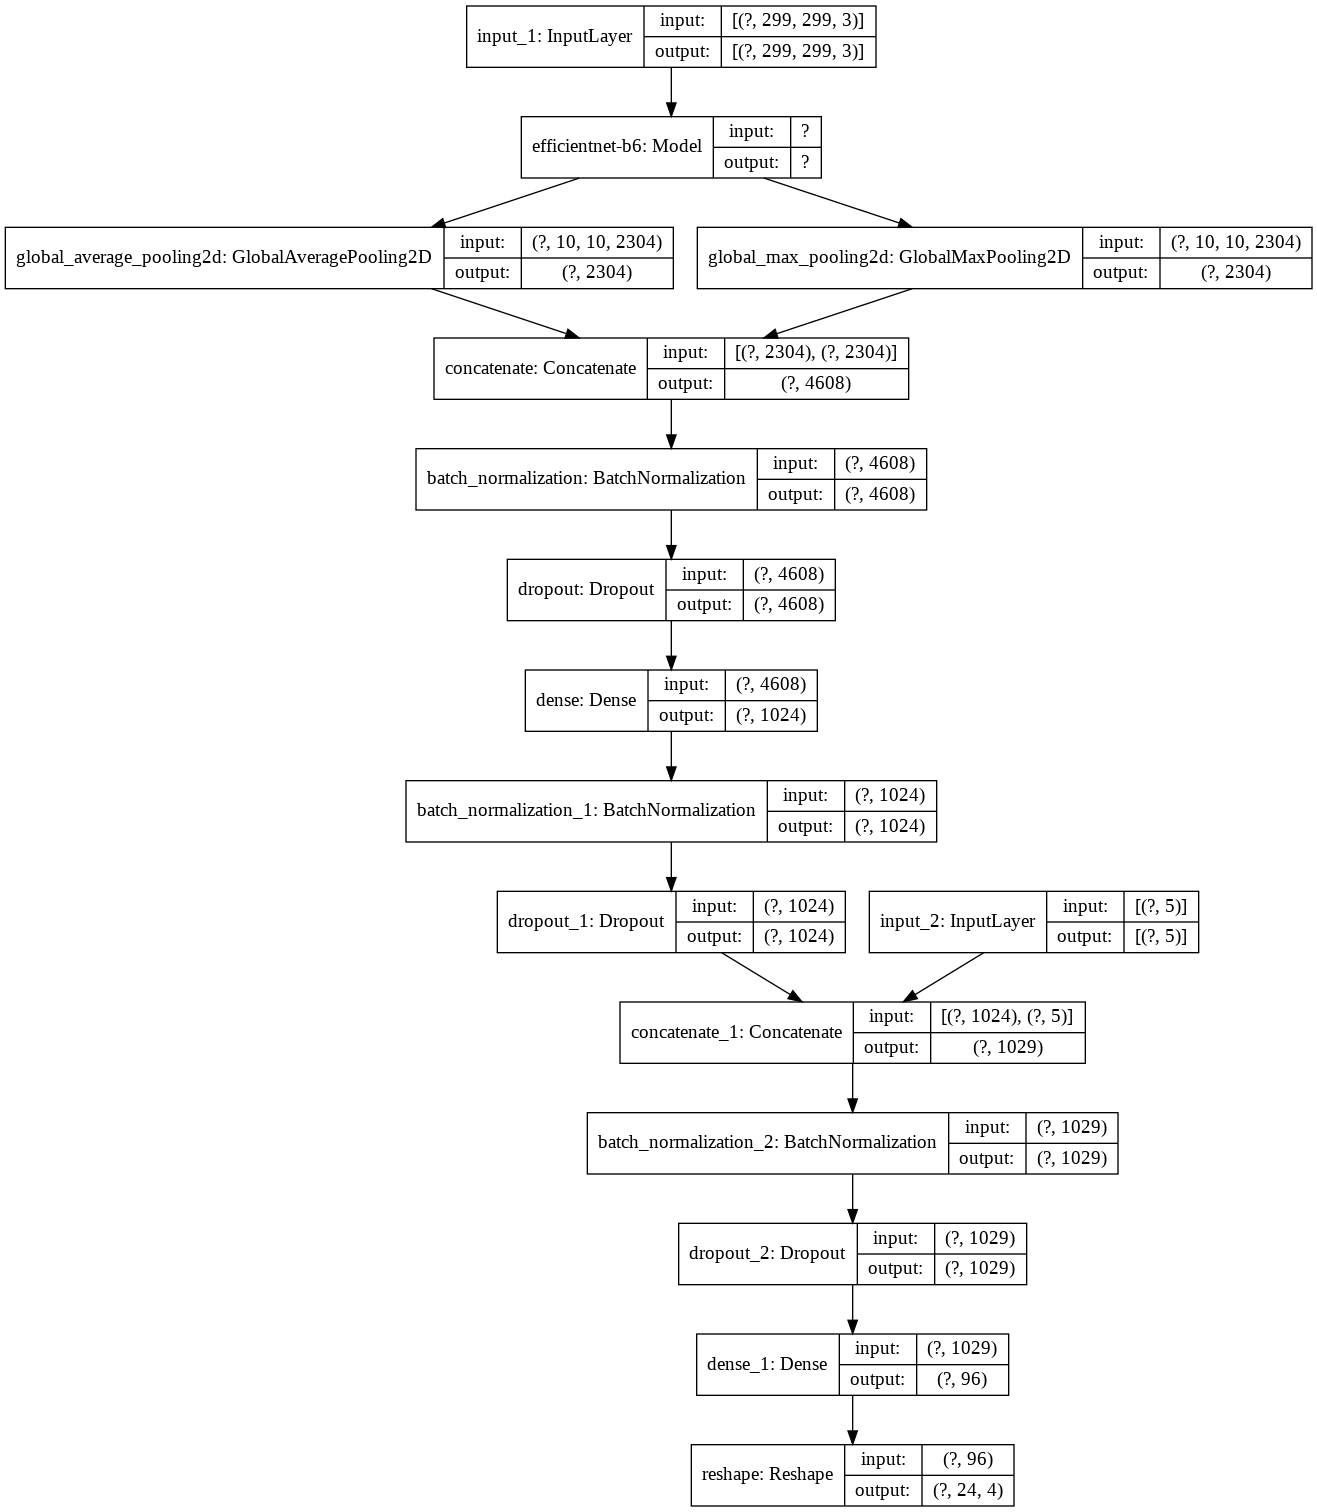

In [62]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARN_RATE),
    loss=[tf.keras.losses.BinaryCrossentropy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [64]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    validation_steps=val_dataset_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Train for 1153 steps, validate for 481 steps
Epoch 1/20
1153/1153 [==============================] - 1125s 975ms/step - loss: 0.4210 - binary_accuracy: 0.6987 - val_loss: 0.2527 - val_binary_accuracy: 0.7645
Epoch 2/20
1153/1153 [==============================] - 1019s 884ms/step - loss: 0.2746 - binary_accuracy: 0.7583 - val_loss: 0.2180 - val_binary_accuracy: 0.7743
Epoch 3/20
1153/1153 [==============================] - 1021s 886ms/step - loss: 0.2395 - binary_accuracy: 0.7684 - val_loss: 0.2021 - val_binary_accuracy: 0.7777
Epoch 4/20
1153/1153 [==============================] - 1019s 884ms/step - loss: 0.2220 - binary_accuracy: 0.7724 - val_loss: 0.1922 - val_binary_accuracy: 0.7796
Epoch 5/20
1153/1153 [==============================] - 1012s 878ms/step - loss: 0.2130 - binary_accuracy: 0.7746 - val_loss: 0.1907 - val_binary_accuracy: 0.7794
Epoch 6/20
1153/1153 [==============================] - 1012s 877ms/step - loss: 0.2076 - binary_accuracy: 0.7757 - val_loss: 0.1870 - val_b

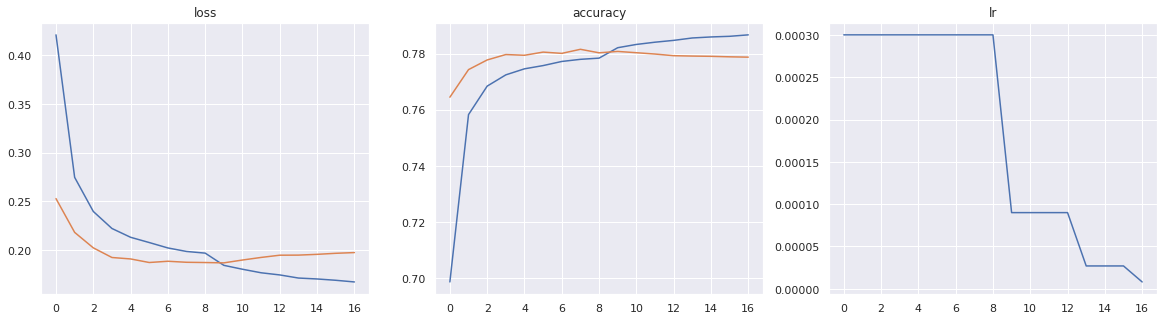

In [70]:
plot_history(model_history, ['loss', 'accuracy', 'lr'], skip=0)

In [66]:
model.evaluate(val_dataset, steps=val_dataset_steps)

481/481 [==============================] - 80s 165ms/step - loss: 0.1867 - binary_accuracy: 0.7808


[0.18667451986218192, 0.78075266]

In [0]:
model_name = 'Keypoints'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history, save_model=True, load_model=True)

In [0]:
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARN_RATE),
    loss=[tf.keras.losses.BinaryCrossentropy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [69]:
loaded_model.evaluate(val_dataset, steps=val_dataset_steps)

481/481 [==============================] - 83s 173ms/step - loss: 0.1867 - binary_accuracy: 0.7808


[0.18667451986218192, 0.78075266]

## ***The End***